In [94]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
from scipy.interpolate import interp1d
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

## Perform alignment

In [75]:
def interpolate(arr, default_val=0):
    """Linearly interpolate default_val values.
    
    Parameters
    ----------
    arr : numpy.ndarray
        Any 2D array. Interpolation is done over the
        second axis.
    default_val : int or float
        The value in arr that gets interpolated.
    
    Returns
    -------
    arr : numpy.ndarray
        The interpolated array, with matching
        dimensions to the input array.
    """
    shp = arr.shape
    if arr.ndim == 1:
        arr = np.expand_dims(arr, axis=0)
    for xind in range(arr.shape[0]):
        keep_inds = np.where(arr[xind, :]!=default_val)[0]
        fill_inds = np.where(arr[xind, :]==default_val)[0]
        f = interp1d(keep_inds, arr[xind, keep_inds], 
                     kind='linear', fill_value='extrapolate')
        arr[xind, fill_inds] = f(fill_inds)
    return arr.reshape(shp)

In [74]:
step = 5 
default_val = -1

arr = np.arange(0, 101, step=step)
print('arr:', arr.shape, arr, end='\n\n')

v = np.repeat(arr, step)
print('v:', v.shape, v, end='\n\n')

mask = np.arange(len(v), step=step)
v[[x for x in np.arange(len(v)) if x not in mask]] = default_val
print('v:', v.shape, v, end='\n\n')

vnew = interpolate(v, default_val=default_val)
print('vnew:', vnew.shape, vnew, end='\n\n')

arr: (21,) [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]

v: (105,) [  0   0   0   0   0   5   5   5   5   5  10  10  10  10  10  15  15  15
  15  15  20  20  20  20  20  25  25  25  25  25  30  30  30  30  30  35
  35  35  35  35  40  40  40  40  40  45  45  45  45  45  50  50  50  50
  50  55  55  55  55  55  60  60  60  60  60  65  65  65  65  65  70  70
  70  70  70  75  75  75  75  75  80  80  80  80  80  85  85  85  85  85
  90  90  90  90  90  95  95  95  95  95 100 100 100 100 100]

v: (105,) [  0  -1  -1  -1  -1   5  -1  -1  -1  -1  10  -1  -1  -1  -1  15  -1  -1
  -1  -1  20  -1  -1  -1  -1  25  -1  -1  -1  -1  30  -1  -1  -1  -1  35
  -1  -1  -1  -1  40  -1  -1  -1  -1  45  -1  -1  -1  -1  50  -1  -1  -1
  -1  55  -1  -1  -1  -1  60  -1  -1  -1  -1  65  -1  -1  -1  -1  70  -1
  -1  -1  -1  75  -1  -1  -1  -1  80  -1  -1  -1  -1  85  -1  -1  -1  -1
  90  -1  -1  -1  -1  95  -1  -1  -1  -1 100  -1  -1  -1  -1]

vnew: (105,) [  0   1   2

In [83]:
lfp_timestamps_copy = lfp_timestamps.copy()

In [89]:
subj_sess = 'U536_ses0'

# # Read events file and get event synctimes.
# events, event_synctimes = events_preproc.read_events_json(subj_sess)

# # Load LFP timestamps.
# lfp_timestamps_micro, sr_micro = spike_sorting.load_lfp_timestamps(subj_sess)

# # ----------------------------------
# # Manual steps...the sync channel for U536_ses0 was recorded at the macro sampling rate (2000Hz),
# # and time stamps were only taken every 512 samples. First load these files and convert timestamps 
# # from µs to ms. Then we'll try linearly interpolating the missing timestamps to get times at 
# # 2000Hz that can be aligned with the event file sync times.

# # Load the sync channel and timestamps.
# sync_chan = events_preproc.load_syncs(subj_sess, basename='sync_channel_macro.mat', data_key='dataSamples')
# lfp_timestamps = events_preproc.load_syncs(subj_sess, basename='sync_channel_macro.mat', data_key='timestamps')
# sr = 2000
# print('lfp_timestamps:', len(lfp_timestamps), '; sync_chan:', len(sync_chan))

# # Convert timestamps from µs to ms, and set the first timestamp to 0ms.
# lfp_timestamps = (lfp_timestamps - lfp_timestamps[0]) * 1e-3

# print('lfp_timestamps_micro:', lfp_timestamps_micro[0], lfp_timestamps_micro[-1])
# print('lfp_timestamps:', lfp_timestamps[0], lfp_timestamps[-1])

# # Linearly interpolate missing timestamps to upsample lfp_timestamps 
# # to the same length as sync_chan.
# step = 512
# default_val = -1
# lfp_timestamps = np.repeat(lfp_timestamps, step)
# mask = np.arange(len(lfp_timestamps), step=step)
# lfp_timestamps[[x for x in np.arange(len(lfp_timestamps)) if x not in mask]] = default_val
# lfp_timestamps = interpolate(lfp_timestamps, default_val=default_val)

# print('lfp_timestamps:', len(lfp_timestamps), '; sync_chan:', len(sync_chan))
# print('lfp_timestamps:', lfp_timestamps[0], lfp_timestamps[-1])
# # ----------------------------------

# Identify sync pulses in the sync channel EEG.
pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                   sampling_rate=sr, 
                                                   pulse_thresh=200, 
                                                   intrapulse_thresh_ms=20, 
                                                   interpulse_thresh_ms=790)
lfp_synctimes = lfp_timestamps[pulse_startinds]
print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

# Find matching sync pulse pairs.
event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                         lfp_synctimes)

# Perform the alignment.
alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                             lfp_synctimes_adj)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes_adj)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
print('\n--------------------\nAlignment parameters\n--------------------')
for k, v in alignment.items():
    print('{}: {}'.format(k, v))

Detected 4110 EEG sync pulses
Detected 4110 syncs for 4095 sync pulse events
Loop 0: Inter-sync times failed to converge
Loop 1: Inter-sync times failed to converge
Loop 2: Inter-sync times failed to converge
Loop 3: Inter-sync times failed to converge
Loop 4: Inter-sync times failed to converge
Loop 5: Inter-sync times failed to converge
Loop 6: Inter-sync times failed to converge
Loop 7: Inter-sync times failed to converge
Loop 8: Inter-sync times failed to converge
Loop 9: Inter-sync times failed to converge
Loop 10: Inter-sync times failed to converge
Retained 3420 sync pulses
3420 event sync pulses
3420 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
sync_params: OrderedDict([('intercept', 187713.44431532588), ('slope', 1.000019005637593)])
before_stats: OrderedDict([('ipi_r', 0.9999999174604658), ('ipi_diff', 0.23312422480664968), ('rmse', 187754.4737071831), ('err_pcts', 0      187719.220912
1      187720.207138
5      187722.699461
10 

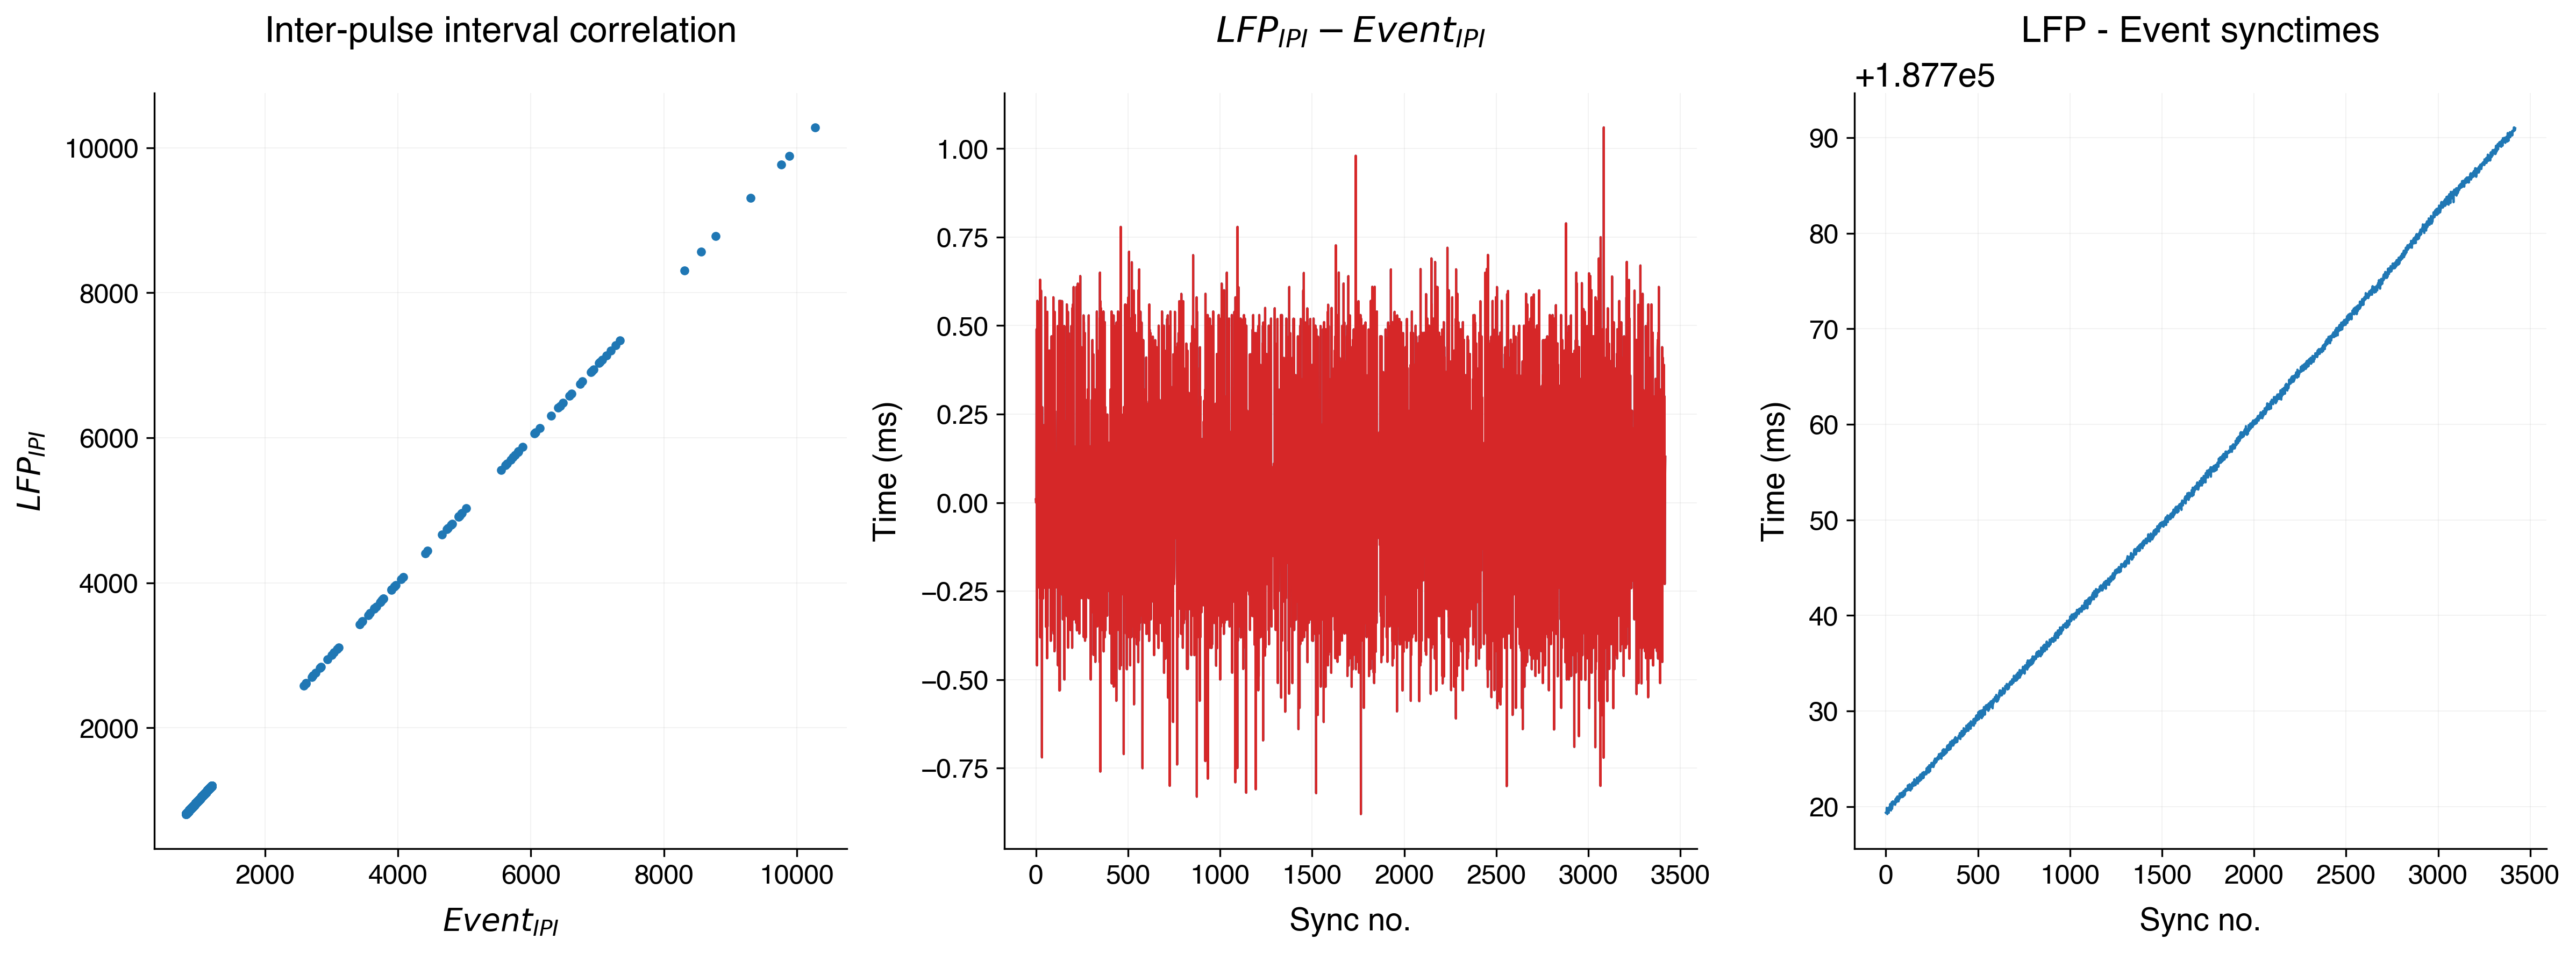

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
ax = np.ravel(ax)

min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
start = 0
stop = None

i = 0
ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

i = 1
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

i = 2
ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
fig.tight_layout()

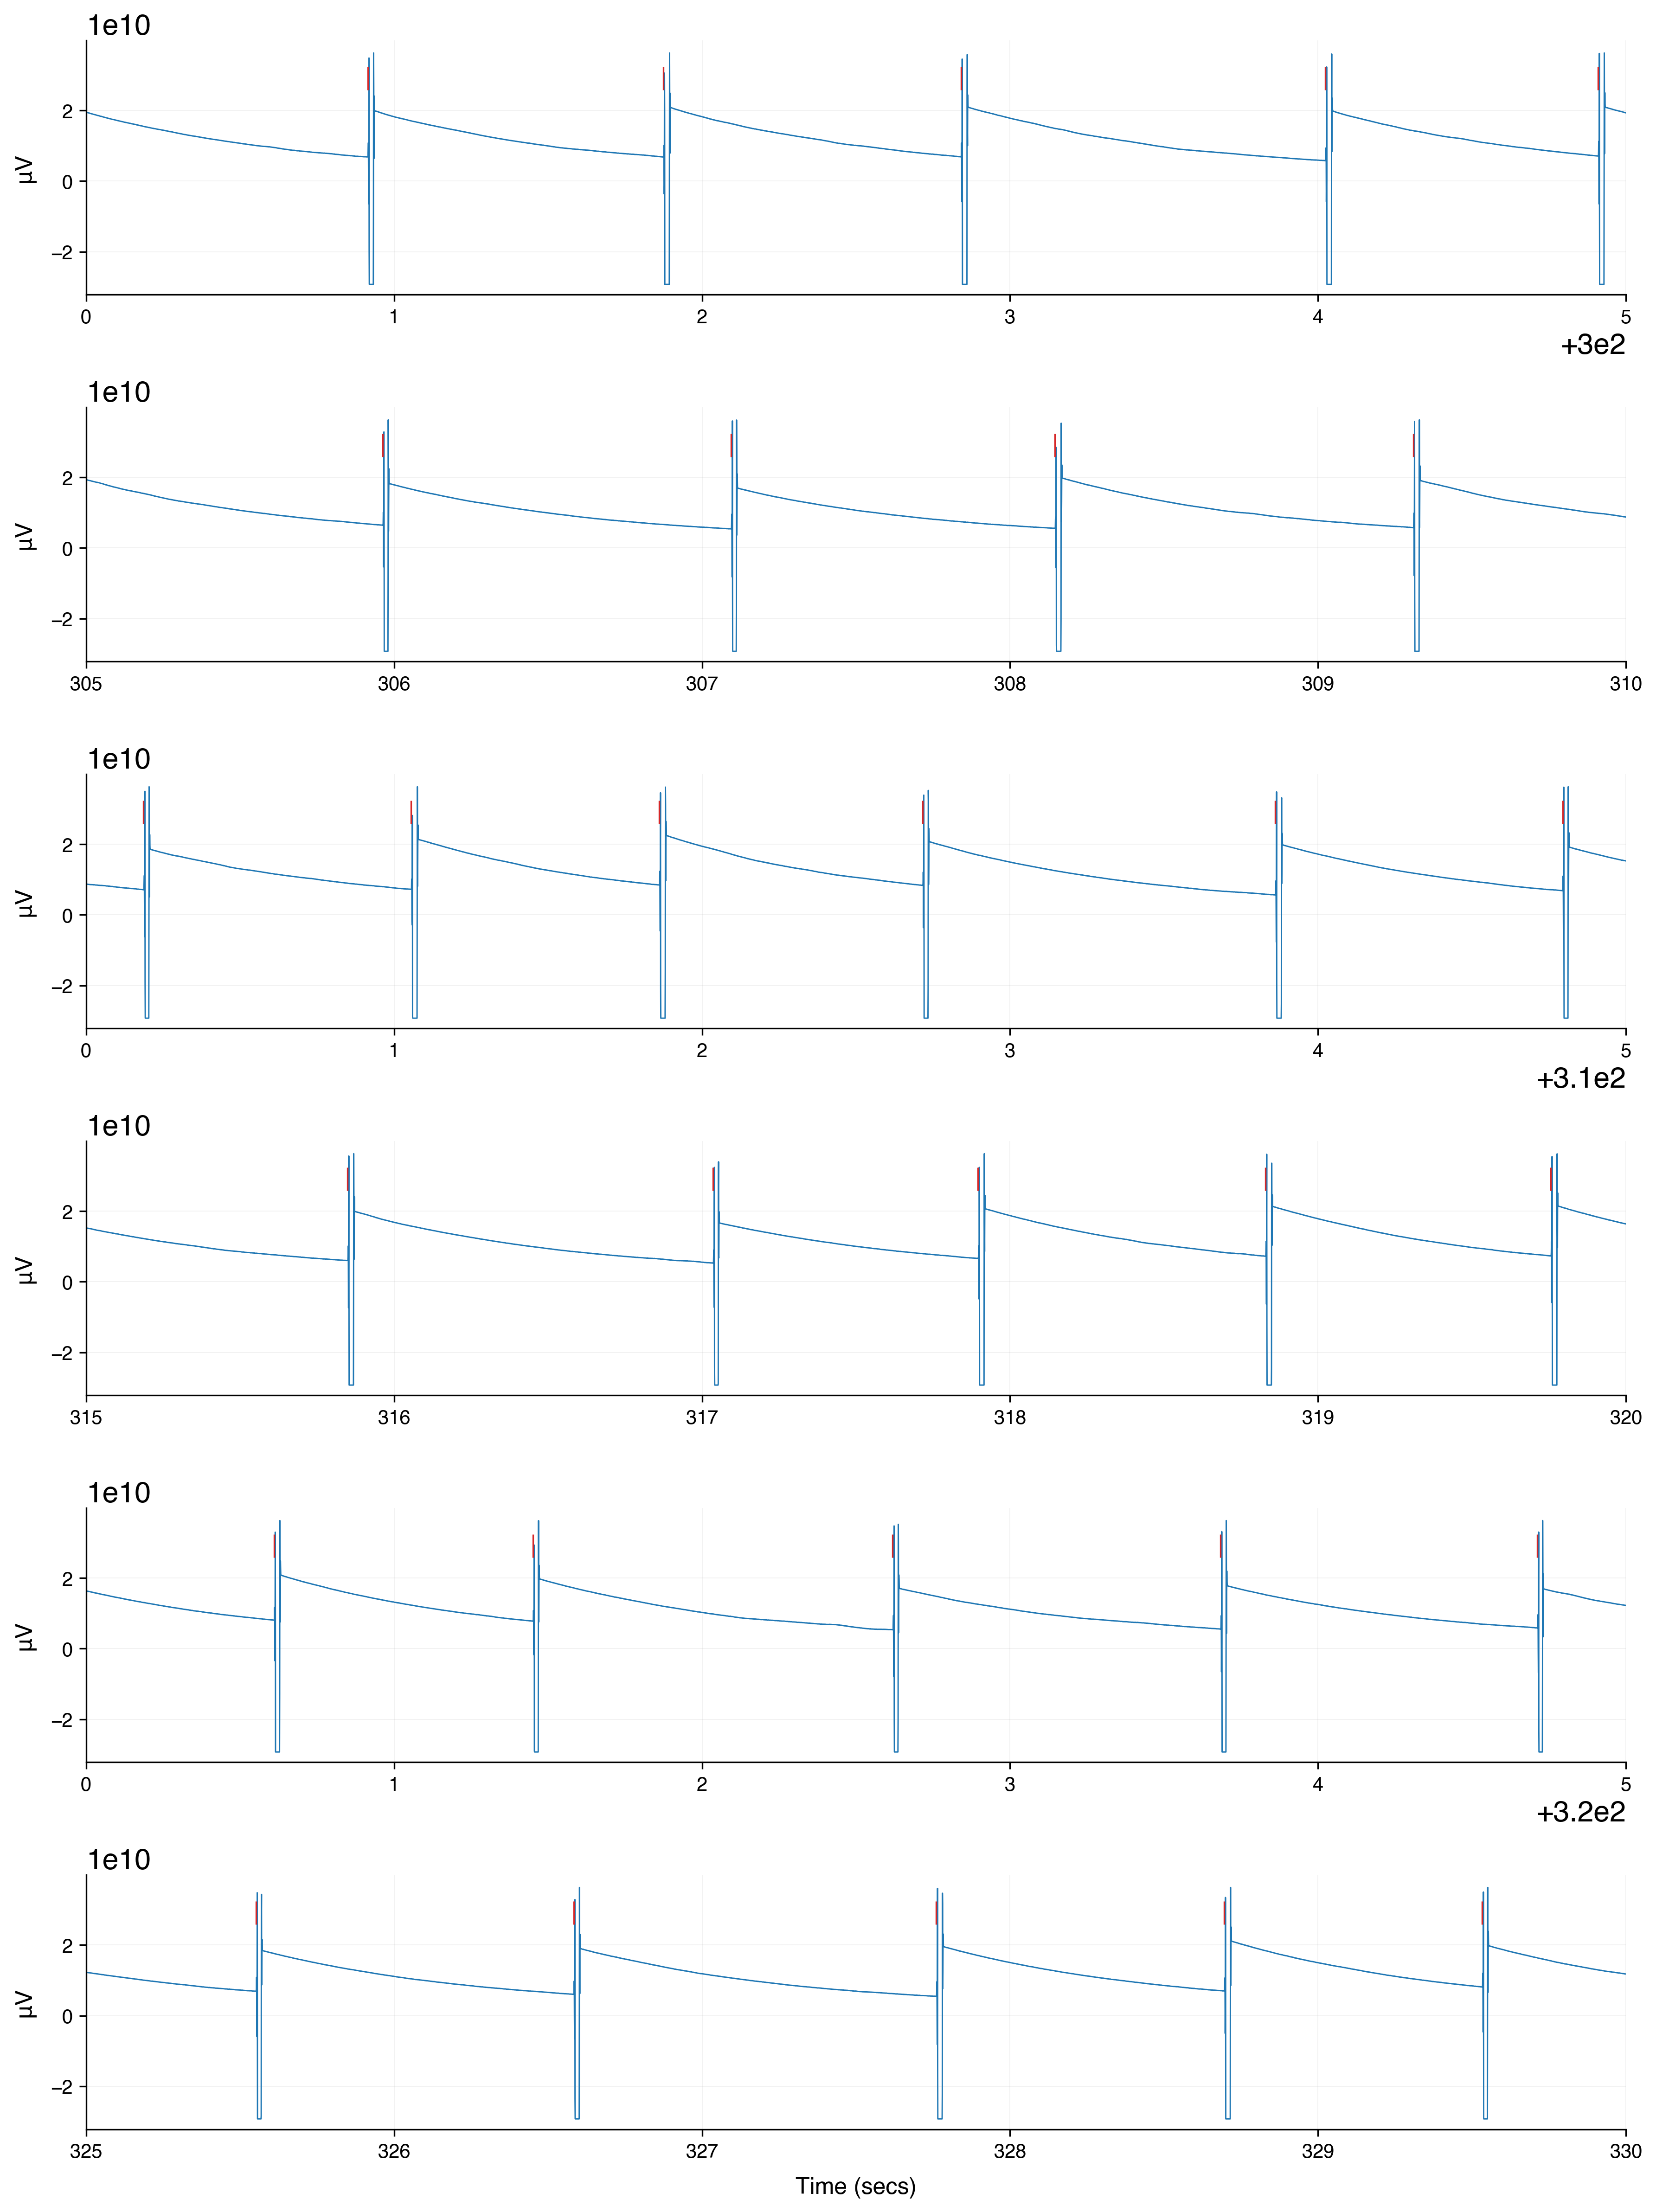

In [99]:
event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                              if x<len(lfp_timestamps)])).astype(np.int64)
event_pulse_startinds_train = np.zeros(len(sync_chan))
event_pulse_startinds_train[event_pulse_inds] = 1

fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                      start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)

## Format events and spikes

In [101]:
proc_events = True
proc_spikes = True
proj_dir = '/home1/dscho/projects/time_cells'
run_all = True
save_output = True
overwrite = False
verbose = True

start_time = time()

print(subj_sess)
if proc_events:
    # Load events and event times.
    print('Processing events data.', end='\n\n')
    events = events_preproc.format_events(events=events,
                                          noisy_trials=[],
                                          remove_incomplete_trials=True,
                                          remove_noisy_trials=False,
                                          remove_paused_trials=False,
                                          overwrite=overwrite,
                                          save_output=save_output,
                                          proj_dir=proj_dir,
                                          verbose=verbose)
    events = events_proc.load_events(subj_sess,
                                     proj_dir=proj_dir,
                                     overwrite=overwrite,
                                     verbose=verbose,
                                     run_all=run_all)
    if save_output:
        events_proc.save_events(events,
                                overwrite=overwrite,
                                verbose=verbose)
    
if proc_spikes:
    # Load spikes.
    print('Processing spikes data.', end='\n\n')
    spikes = spike_preproc.format_spikes(subj_sess,
                                         conv_factor='infer',
                                         fr_thresh=0.1,
                                         overwrite=True,
                                         save_output=True,
                                         split_files=True,
                                         verbose=verbose)

print('Done in {:.2f} s'.format(time() - start_time))

U536_ses0
Done in 0.00 s


In [106]:
print(events)

------------------------------------
U536_ses0
36 trials completed, 36 good

58 gold spawned
52 gold viewed (90%)
32 gold dug (55%)
56 dig attempts (57% accuracy)

dataframe sizes:
	events: (81001, 8)
	event_times: (216, 10)
	positions: (50055, 15)
	base_events: (10007, 7)
	gold_events: (13825, 8)
	gold_spawned: (58, 8)
	dig_events: (56, 8)
	events_behav: (6431, 20)

